# OFDM
## Test bit-error-rate (BER) versus signal-to-noise ratio per bit ($E_b/N_0$)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from optic.ofdm        import modulateOFDM, demodulateOFDM
from optic.modulation  import modulateGray
from optic.dsp         import pnorm
from optic.metrics     import fastBERcalc, theoryBER
from optic.models      import awgn
from tqdm.notebook     import tqdm

In [6]:
# OFDM setting
Nfft = 512             # FFT size
G    = 4               # CP size
hermitSym = False

pilotCarriers = np.array([], dtype = int)   # Pilot subcarriers
Np = len(pilotCarriers)

In [7]:
EbN0dB_  = np.arange(-2, 35)
qamOrder = np.array([4, 16, 64, 256])

BER   = np.zeros((len(EbN0dB_), len(qamOrder)))
BERth = np.zeros(BER.shape)

for ii, M in enumerate(qamOrder):
    print('run sim: M = ', M)
    
    for indSNR in tqdm(range(EbN0dB_.size)):
        EbN0dB = EbN0dB_[indSNR]
        
        # Generate random bits
        if hermitSym:
            bits = np.random.randint(2, size = int(np.log2(M)*(Nfft//2 - 1 - Np))*2**8)
        else:
            bits = np.random.randint(2, size = int(np.log2(M)*(Nfft - Np))*2**8)
        
        # Map bits to constellation symbols
        symbTx = modulateGray(bits, M, 'qam')
        symbTx = pnorm(symbTx)

        # Pilot symbol choice
        pilot = max(symbTx.real) + 1j*max(symbTx.imag)
        
        # OFDM symbols modulation
        symbTx_OFDM = modulateOFDM(Nfft, G, pilot, pilotCarriers, symbTx, hermitSym)
        
        # AWGN channel
        snrdB  = EbN0dB + 10*np.log10(np.log2(M))
        symbRx_OFDM = awgn(symbTx_OFDM, snrdB)
        
        # OFDM symbols demodulation
        symbRx = demodulateOFDM(Nfft, G, pilot, pilotCarriers, symbRx_OFDM, hermitSym)
        
        discard = 100
        ind = np.arange(discard, len(symbRx) - discard)
        
        # BER calculation
        BER[indSNR, ii], _, _ = fastBERcalc(symbRx[ind], symbTx[ind], M, 'qam')
        BERth[indSNR, ii] = theoryBER(M, EbN0dB, 'qam')
        
        if BER[indSNR, ii] == 0:              
            break

run sim: M =  4


  0%|          | 0/37 [00:00<?, ?it/s]

run sim: M =  16


  0%|          | 0/37 [00:00<?, ?it/s]

run sim: M =  64


  0%|          | 0/37 [00:00<?, ?it/s]

run sim: M =  256


  0%|          | 0/37 [00:00<?, ?it/s]

C:\Users\embedded05\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  
C:\Users\embedded05\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()


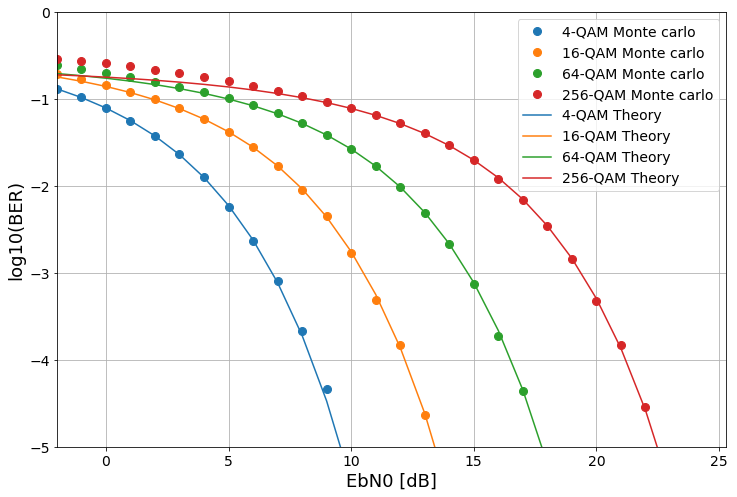

In [8]:
# Plot simulation results and theoretical curves        

plt.figure(figsize=(12, 8))

for ii, M in enumerate(qamOrder):
    plt.plot(EbN0dB_, np.log10(BER[:,ii]),'o', ms = 8, label = str(M)+'-QAM Monte Carlo')

plt.gca().set_prop_cycle(None)

for ii, M in enumerate(qamOrder):
    plt.plot(EbN0dB_, np.log10(BERth[:,ii]), label = str(M)+'-QAM Theory')

plt.ylim(-5, 0)
plt.xlim(min(EbN0dB_))
plt.xlabel('EbN0 [dB]', fontsize = 18)
plt.ylabel('log10(BER)', fontsize = 18)
plt.legend(fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.grid()